# SMAI Assignment - 2

## Question - `2` : Face Recognition using Principal Component Analysis

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

### <b>Objective:</b>
This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

### <b>About the dataset:</b>  
The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)



### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.


#### Import Libraries

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [138]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []       # array of cv2 images
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Treating each pixel as a feature results in a (w\*h)x(w\*h) covariance matrix. Finding the eigenvalues/vectors for this matrix is not even feasible (I even tried with cuda).
But since we just have 400 images which is << than the number of features, there will only be 400 meaningful eignenvectors


If $A^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}\bold{v}_{\textit{i}}$, 
<br>pre-multiply A to get<br>
$AA^TA \bold{v}_{\textit{i}} = \mu_{\textit{i}}A\bold{v}_{\textit{i}}$, 

Thus, $A\bold{v}_{\textit{i}}$ is an eigenvalue for $AA^T$ for all $\textit{i}$

Instead of decomposing $AA^T$, we decompose $A^TA$ instead. $A\bold{v}_{\textit{i}}$ describes a linear combination of faces that can produce any face in face-space

In [139]:
"""
Implement pca in the following function by taking the following arguements:
1. X(images array)
2. number of components
The function must return the eigen vectors (principal components) also termed "Eigen faces"
"""

%matplotlib inline

def principalComponentAnalysis(x, numComponents=50):
    numImages = x.shape[0]

    # normalise data, (subtract avg face)
    imgVectors = (x.reshape(numImages, -1)).astype(np.float64)
    psi = np.mean(imgVectors, axis=0).astype(np.float64)     # aka meanFace

    # sigma = np.sum(np.square((imgVectors - mu).astype(np.float64)), axis=0)/imgVectors.shape[0]
    # sigma = np.sqrt(sigma)

    nImgVectors = imgVectors - psi       # aka Phi

    # generate a covariance matrix and eigen values
    print("Generating covariance matrix...")
    L = nImgVectors@nImgVectors.T  # AT A in the paper

    print("Generating eigenfaces...")
    eigenvalues, eigenvectors = np.linalg.eigh(L)   # 360 eigenvalues/vectors
    order = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors.T[order]


    # # print((cov)@eigenvectors[:,-1] - eigenvalues[-1]*eigenvectors[:,-1])

    eigenfaces = (eigenvectors@nImgVectors)

    return eigenfaces[:numComponents], psi

Generating covariance matrix...
Generating eigenfaces...


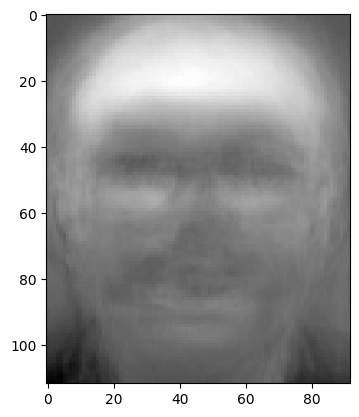

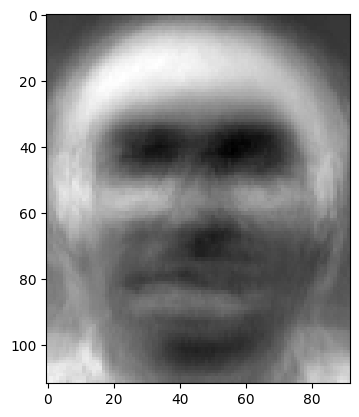

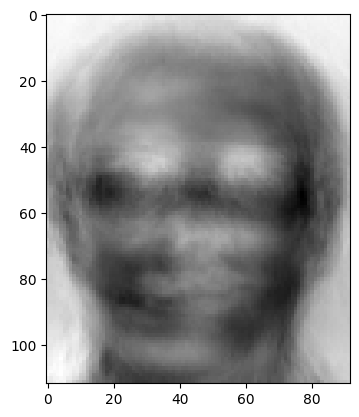

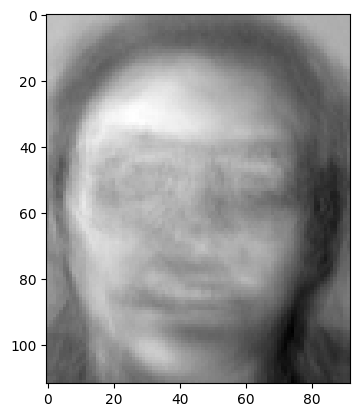

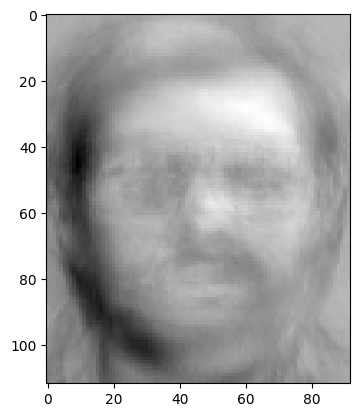

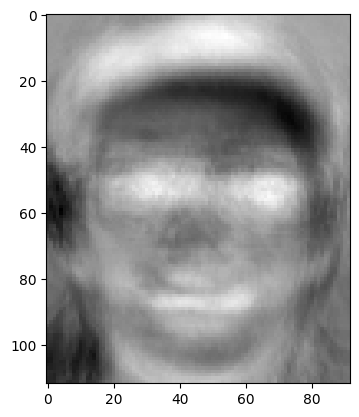

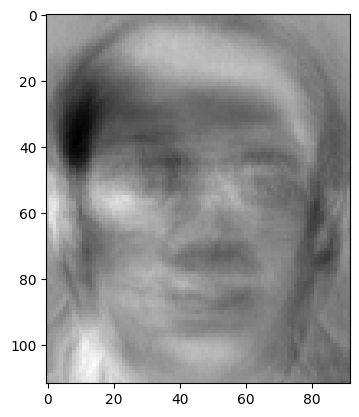

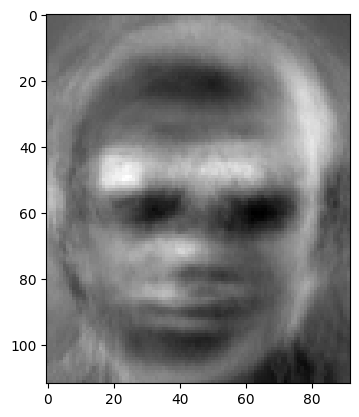

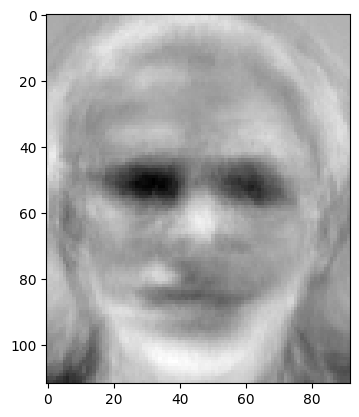

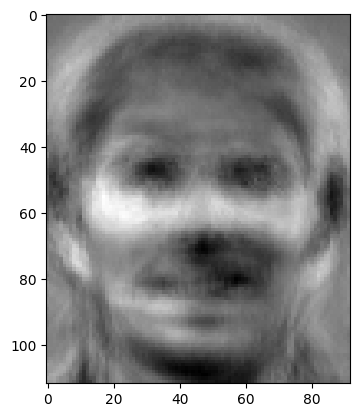

In [140]:
eigenfaces, meanFace = principalComponentAnalysis(trainFaces, 200)
%matplotlib inline
for i in eigenfaces[:10]:
    plt.imshow(i.reshape(112,92), cmap='gray')
    plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [141]:
%matplotlib inline

# Function to implement image reconstruction by taking arguements as necessary.
def imageReconstruction(testFace, eigenfaces, meanFace, q=False):
    reconstructedFace = np.zeros_like(testFace, dtype=np.float64)

    for ef in eigenfaces:
        reconstructedFace += ((ef.T@(testFace - meanFace)) * ef)/np.linalg.norm(ef)     # use the weights to reconstruct the face in facespace
        # reconstructedFace += ((ef.T@(testFace - meanFace)) * ef)     # use the weights to reconstruct the face in facespace
    
    print(reconstructedFace)

    # reconstructedFace /= len(eigenfaces)                                                # normalise to img coords
    # reconstructedFace *= 255

    print(reconstructedFace)

    if not q:
        print("Test: ", testFace[:10], "\nMean: ", meanFace[:10],'\nRec: ', reconstructedFace[:10]/10000)

    return (reconstructedFace + meanFace).reshape(112,92)                               # return the face

Generating covariance matrix...
Generating eigenfaces...
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
Test:  [44 44 47 42 50 45 47 48 48 43] 
Mean:  [86.38888889 86.35277778 86.71666667 86.67777778 86.77777778 87.04722222
 86.875      86.72222222 86.95555556 86.96111111] 
Rec:  [-95.86231551 -96.92847582 -95.29259698 -98.42790169 -95.326221
 -96.0614546  -94.23752621 -95.31981771 -95.66718521 -97.4656514 ]


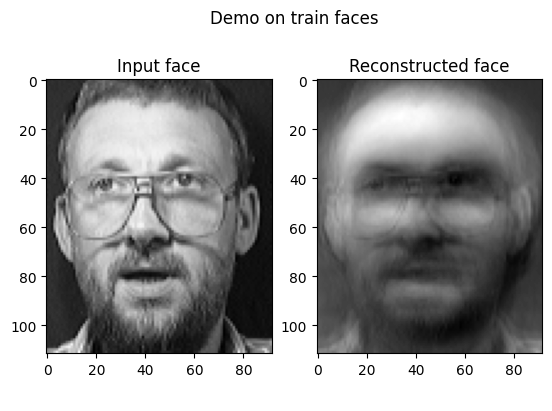

[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]
[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]
Test:  [93 93 88 90 89 88 92 89 90 92] 
Mean:  [86.38888889 86.35277778 86.71666667 86.67777778 86.77777778 87.04722222
 86.875      86.72222222 86.95555556 86.96111111] 
Rec:  [19.86609426 19.40096162 20.08401556 19.408314   18.66998559 15.19325068
 15.67756723 18.85712829 17.65843296 11.46186389]


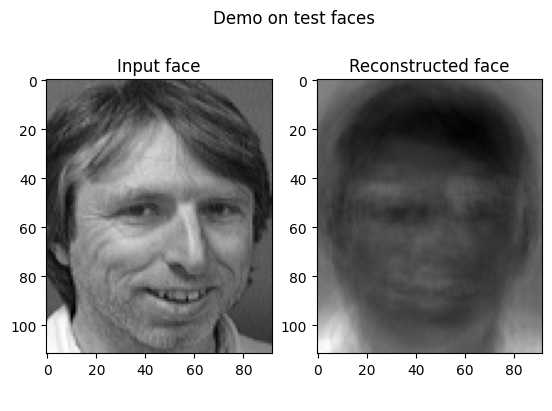

In [142]:
# demonstrate PCA

%matplotlib inline

eigenfaces, meanFace = principalComponentAnalysis(trainFaces, 360)

faceNum = 1

trainImg = trainFaces[6]
testImg = testFaces[18]

# train

rTrainImg = imageReconstruction(trainImg.reshape(-1), eigenfaces, meanFace)

fig, ax = plt.subplots()
plt.title("Demo on train faces")
ax.axis('off')

fig.add_subplot(1,2,1)
plt.imshow(trainImg.reshape(112,92), cmap='gray')
plt.title("Input face")

fig.add_subplot(1,2,2)
plt.imshow(rTrainImg, cmap='gray')
plt.title("Reconstructed face")

plt.show()

# test

rTestImg = imageReconstruction(testImg.reshape(-1), eigenfaces, meanFace)

fig, ax = plt.subplots()
plt.title("Demo on test faces")
ax.axis('off')

fig.add_subplot(1,2,1)
plt.imshow(testImg.reshape(112,92), cmap='gray')
plt.title("Input face")

fig.add_subplot(1,2,2)
plt.imshow(rTestImg, cmap='gray')
plt.title("Reconstructed face")

plt.show()



#### Visualisation
Visualise the results for different number of principal components(pc = 5,10,100, 1000, all).

**Note:** Ensure that the images are labelled appropriately.

Generating covariance matrix...
Generating eigenfaces...
[-926487.15907431 -924492.83159483 -919719.15623301 ...  119086.60550402
  129034.57976711   18170.44250484]
[-926487.15907431 -924492.83159483 -919719.15623301 ...  119086.60550402
  129034.57976711   18170.44250484]
[ 171819.72076707  168822.0631707   175683.68471652 ... 1219287.89636255
 1169727.66143672 1201984.94634287]
[ 171819.72076707  168822.0631707   175683.68471652 ... 1219287.89636255
 1169727.66143672 1201984.94634287]


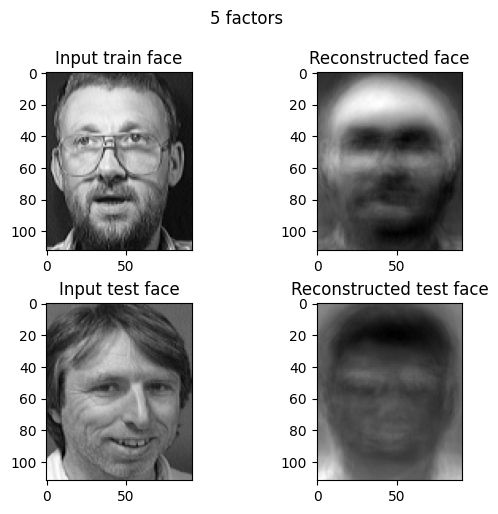

Generating covariance matrix...
Generating eigenfaces...
[-899458.80164318 -904840.45801322 -902080.67695423 ...  309707.55592219
  310894.58157679  199661.31708089]
[-899458.80164318 -904840.45801322 -902080.67695423 ...  309707.55592219
  310894.58157679  199661.31708089]
[ 197867.6627123   196775.31181191  203242.58945304 ... 1167121.68043514
 1118526.6349155  1154408.72035193]
[ 197867.6627123   196775.31181191  203242.58945304 ... 1167121.68043514
 1118526.6349155  1154408.72035193]


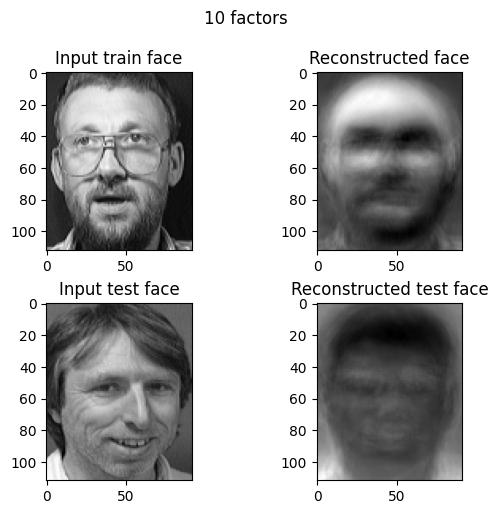

Generating covariance matrix...
Generating eigenfaces...
[-951239.40655727 -956208.60771795 -944146.76104023 ...  619206.97137216
  584504.14998542  375751.51741316]
[-951239.40655727 -956208.60771795 -944146.76104023 ...  619206.97137216
  584504.14998542  375751.51741316]
[ 226851.8841579   231554.67885436  233907.49778877 ... 1112798.58635118
 1079311.41272489 1118760.13881357]
[ 226851.8841579   231554.67885436  233907.49778877 ... 1112798.58635118
 1079311.41272489 1118760.13881357]


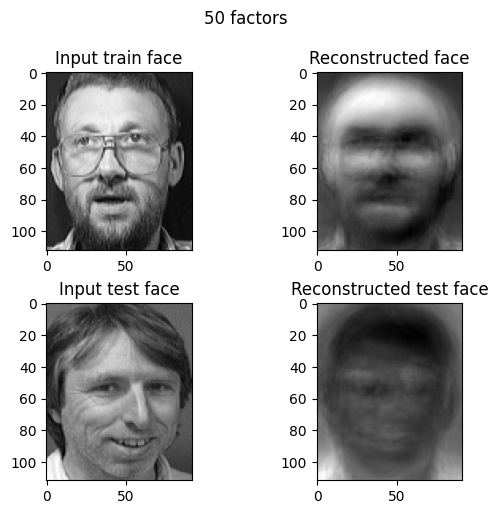

Generating covariance matrix...
Generating eigenfaces...
[-944465.28518735 -960869.53378299 -944845.72528162 ...  709125.55898108
  650420.48145779  410270.84874336]
[-944465.28518735 -960869.53378299 -944845.72528162 ...  709125.55898108
  650420.48145779  410270.84874336]
[ 187373.79653828  186338.39330456  196094.30856351 ... 1164306.74319834
 1099396.1095412  1120490.69536929]
[ 187373.79653828  186338.39330456  196094.30856351 ... 1164306.74319834
 1099396.1095412  1120490.69536929]


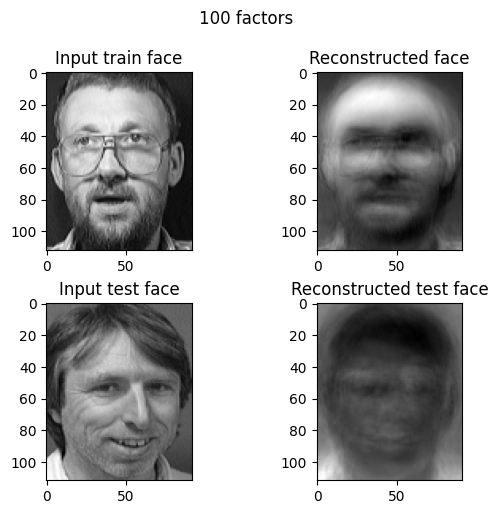

Generating covariance matrix...
Generating eigenfaces...
[-950300.23916458 -964250.12535814 -948175.75442884 ...  735866.94564165
  662311.61661495  400263.07022347]
[-950300.23916458 -964250.12535814 -948175.75442884 ...  735866.94564165
  662311.61661495  400263.07022347]
[ 198230.93451316  194415.64047881  203063.72283897 ... 1170894.02178614
 1091588.58229573 1104867.4524063 ]
[ 198230.93451316  194415.64047881  203063.72283897 ... 1170894.02178614
 1091588.58229573 1104867.4524063 ]


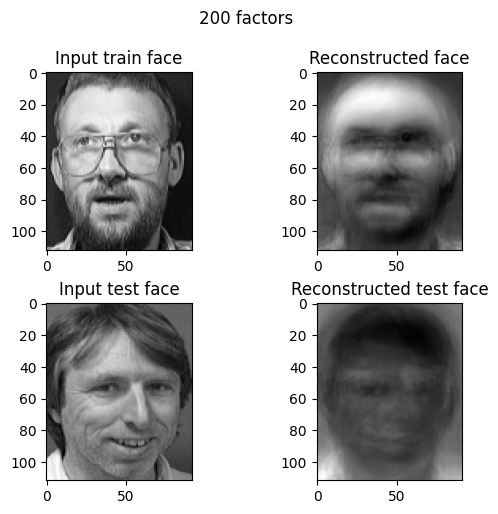

Generating covariance matrix...
Generating eigenfaces...
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]
[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]


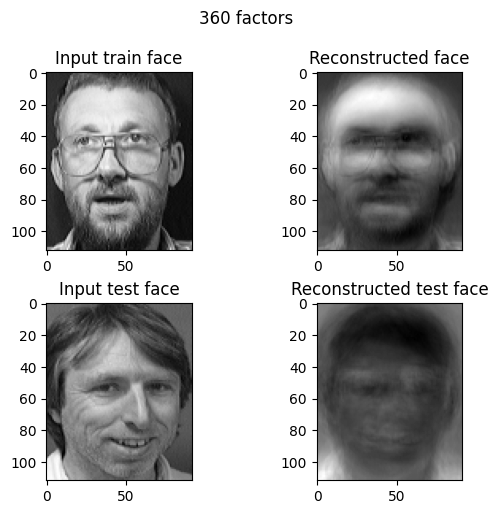

Generating covariance matrix...
Generating eigenfaces...
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
[-958623.15505669 -969284.75817688 -952925.96975179 ...  727812.57481088
  655991.42637659  377018.95858247]
[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]
[ 198660.94257737  194009.61616245  200840.15557066 ... 1160877.19590506
 1085695.94766616 1098407.90477772]


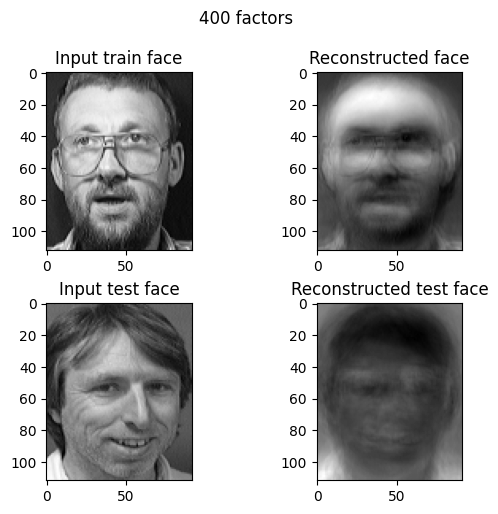

In [143]:
# Visualise the effect of factors

%matplotlib inline

def displayNFacors(n, trainNum=6, testNum=18):
    eigenfaces, meanFace = principalComponentAnalysis(trainFaces, n)

    trainImg = trainFaces[trainNum]
    # testImg = testFaces[testNum]

    # train

    rTrainImg = imageReconstruction(trainImg.reshape(-1), eigenfaces, meanFace, q=True)


    plt.subplot(2,2,1)
    plt.imshow(trainImg.reshape(112,92), cmap='gray')
    plt.title("Input train face")

    plt.subplot(2,2,2)
    plt.imshow(rTrainImg, cmap='gray')
    plt.title("Reconstructed face")

    rTestImg = imageReconstruction(testImg.reshape(-1), eigenfaces, meanFace, q=True)

    plt.subplot(2,2,3)
    plt.imshow(testImg.reshape(112,92), cmap='gray')
    plt.title("Input test face")

    plt.subplot(2,2,4)
    plt.imshow(rTestImg, cmap='gray')
    plt.title("Reconstructed test face")

    plt.subplots_adjust(bottom=0, top=0.85, hspace=0.3)
    plt.suptitle("%d factors" % n)
    plt.show()

displayNFacors(5)
displayNFacors(10)
displayNFacors(50)
displayNFacors(100)
displayNFacors(200)
displayNFacors(360)
displayNFacors(400)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [144]:
"""
Implement pca in the following function by taking the following arguements:
1. Test image
2. Eigenvectors
3. Mean Eigen Face
4. Training Set(X_train,y_train)
The function must return the following:
1. image with smallest error
2. error value
3. prediction class
"""
def generateClassVectors(trainFaces, trainLabels, numFactors):
    # train PCA
    eigenfaces, meanFace = principalComponentAnalysis(trainFaces, numFactors)

    # get average weights per class
    numClasses = np.unique(trainLabels).shape[0]

    flattenedFaces = trainFaces.reshape(trainFaces.shape[0], -1)
    classCounts = np.zeros(numClasses)
    
    classWeights = np.zeros((numClasses, len(eigenfaces)))
    classVectors = np.zeros((numClasses, flattenedFaces.shape[-1]))

    # construct the average face for each class
    for face, label in zip(flattenedFaces, trainLabels):
        reconstructedFace = np.zeros(flattenedFaces.shape[-1])
        weights = eigenfaces@(face-meanFace)

        for ef in eigenfaces:
            reconstructedFace += ((ef.T@(face - meanFace)) * ef)/np.linalg.norm(ef)

        # reconstructedFace /= len(eigenfaces)
        # reconstructedFace *= 255

        classVectors[label-1] += reconstructedFace
        classWeights[label-1] = weights
        classCounts += 1

    # normalise by images seen, classify acc to the label
    classVectors /= classCounts[:, np.newaxis]
    return classWeights, classVectors, eigenfaces, meanFace


def getClass(face, classWeights, eigenfaces, meanFace):
    flattenedFace = face.reshape(-1)
    reconstructedFace = np.zeros(flattenedFace.shape)
    
    # project the given face into facespace
    weights = eigenfaces@(flattenedFace - meanFace)

    for ef in eigenfaces:
        reconstructedFace += ((ef.T@(flattenedFace - meanFace)) * ef)/np.linalg.norm(ef)

    # reconstructedFace /= len(eigenfaces)
    # reconstructedFace *= 255

    # compare  costs, get the minimumm cost and the associated label
    mindist = np.Inf
    predictedLabel = 0
    for i, cv in enumerate(classWeights):
        d = np.linalg.norm(cv - weights)
        
        if d < mindist:
            mindist = d
            predictedLabel = (i+1)  # zero indexing

    return predictedLabel, mindist


classWeights, classVectors, ef, mf = generateClassVectors(trainFaces, trainLabels, 20)
    

Generating covariance matrix...
Generating eigenfaces...


In [145]:
fNum = 24

# cv = classVectors.reshape((-1,112,92))
# print(cv.shape)

# plt.imshow(cv[14])
# plt.show()

count = 0 
correct = 0
for face, label in tqdm(zip(trainFaces, trainLabels)):
    predlabel, mindist = getClass(face, classWeights, ef, mf)

    # print("Predicted: ", predlabel, " | Actual: ", label, mindist)
    if predlabel == label:
        correct += 1
    count += 1

print("Train results")
print("Got ", correct, " correct out of ", count, ". Accuracy: ", str(100 * float(correct)/count), "%")

360it [00:01, 286.03it/s]

Train results
Got  238  correct out of  360 . Accuracy:  66.11111111111111 %


In [146]:
count = 0 
correct = 0
for face, label in tqdm(zip(testFaces, testLabels)):
    predlabel, mindist = getClass(face, classWeights, ef, mf)

    # print("Predicted: ", predlabel, " | Actual: ", label, mindist)
    if predlabel == label:
        correct += 1
    count += 1

print("Test results")
print("Got ", correct, " correct out of ", count, ". Accuracy: ", str(100 * float(correct)/count), "%")

40it [00:00, 358.21it/s]

Test results
Got  28  correct out of  40 . Accuracy:  70.0 %


In [ ]:
"""
Iterate through all the images in the test data and 
test the accurate by taking different number of components
"""

In [ ]:
# Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# Plot Number of eigenvectors vs Logarithmic Mean Square Error

Summarise your observations on the plots and accuracies

**Answer:**

State the advantages and limitations of using PCA in general. Also state its limitations in context of face recognition

**Answer:**